/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0054 - val_loss: 1.0753e-04
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.2195e-04 - val_loss: 9.2024e-05
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.7226e-04 - val_loss: 7.2136e-05
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.5090e-04 - val_loss: 5.9106e-05
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.4673e-04 - val_loss: 5.3438e-05
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.0421e-05 - val_loss: 8.7796e-05
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4048e-04 - val_loss: 4.7517e-05
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.0900e-04 - val_loss: 4.7716e-05
Epoch 9/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0570e-04 - val_loss: 5.7519e-05
Epoch 10/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.0310e-05 - val_loss: 3.9328e-05
Epoch 11/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

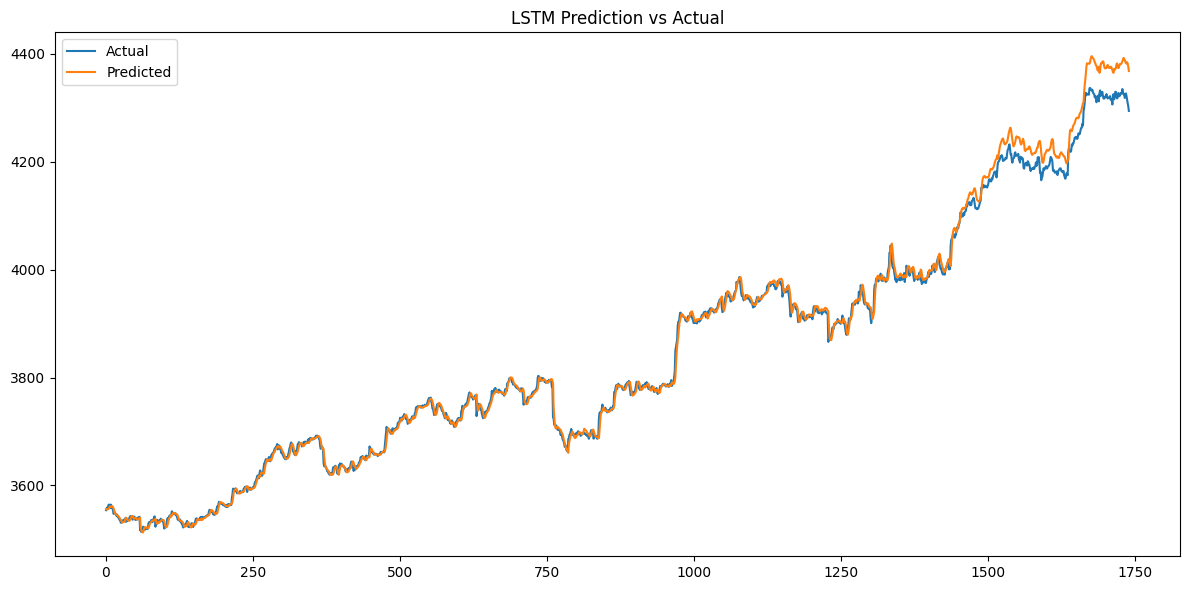

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, ReLU
from tensorflow.keras.callbacks import EarlyStopping

# --- Load & preprocess dataset ---
df = pd.read_csv("/content/ATHEX_DLY_FTSE_15_15min.csv").tail(6000)
df.drop(columns=['Volume'], inplace=True)
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df.dropna(subset=['time'], inplace=True)
df.sort_values(by='time', inplace=True)
df.set_index('time', inplace=True)

# Technical indicators
df['ema_5'] = df['close'].ewm(span=5, adjust=False).mean()
df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()
df['ema_15'] = df['close'].ewm(span=15, adjust=False).mean()

# Features and target
features = ['open', 'high', 'low', 'ema_5', 'ema_10', 'ema_15']
target = 'close'

# Scale features
feature_scaler = MinMaxScaler()
df[features] = feature_scaler.fit_transform(df[features])

# Scale target
target_scaler = MinMaxScaler()
df[[target]] = target_scaler.fit_transform(df[[target]])

# Split train/test
train_size = int(len(df) * 0.7)
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]

X_train_raw, y_train_raw = train_df[features], train_df[target]
X_test_raw, y_test_raw = test_df[features], test_df[target]

# Create sequences
def create_sequences(X, y, seq_length=60):
    Xs, ys = [], []
    for i in range(seq_length, len(X)):
        Xs.append(X.iloc[i-seq_length:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 60
X_train, y_train = create_sequences(X_train_raw, y_train_raw, SEQ_LEN)
X_test, y_test = create_sequences(X_test_raw, y_test_raw, SEQ_LEN)

# --- Model ---
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.001))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.001))
model.add(ReLU())  # <-- Added ReLU activation
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Train ---
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Save Model (.keras format) ---
file_path = "/content/ATHEX_DLY_FTSE_15_15min.csv"
indice_name = os.path.splitext(os.path.basename(file_path))[0].replace(",", "")
model_filename = f"{indice_name}_prediction_model.keras"
model_path = os.path.join("/content", model_filename)
model.save(model_path)
print(f"💾 Model saved as: {model_path}")

# --- Predict & inverse scale ---
pred_scaled = model.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)

pred_actual = target_scaler.inverse_transform(pred_scaled)
y_actual = target_scaler.inverse_transform(y_test_scaled)

# --- Save basic predictions to CSV ---
datetime_test = test_df.index[SEQ_LEN:]
predictions_df = pd.DataFrame({
    'datetime': datetime_test,
    'actual': y_actual.flatten(),
    'predicted': pred_actual.flatten()
})
predictions_df.to_csv('spx_lstm_predictions.csv', index=False)
print("✅ Basic predictions saved to 'spx_lstm_predictions.csv'")

# --- Evaluation ---
mae = mean_absolute_error(y_actual, pred_actual)
rmse = np.sqrt(mean_squared_error(y_actual, pred_actual))
mape = mean_absolute_percentage_error(y_actual, pred_actual)
accuracy = 100 - (mape * 100)

print(f"\n📊 Final Evaluation:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAPE : {mape:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

# --- Plot (display only) ---
plt.figure(figsize=(12,6))
plt.plot(y_actual, label='Actual')
plt.plot(pred_actual, label='Predicted')
plt.title('LSTM Prediction vs Actual')
plt.legend()
plt.tight_layout()
plt.show()


In [111]:
import os
import pandas as pd

# Define the save path
save_path = '/content/Features.csv'

# Delete existing 'Features.csv' if it exists
if os.path.exists(save_path):
    os.remove(save_path)
    print("Existing 'Features.csv' deleted.")

# Create a dictionary with the data
data = {
    'Dataset': ['ATHEX_DLY_FTSE_15_15min'],
    'Features': [['open', 'high', 'low', 'EMA_5', 'EMA_10', 'EMA_15']]
}

# Create a Pandas DataFrame
features_df = pd.DataFrame(data)

# Convert 'Features' column to a comma-separated string with single quotes
features_df['Features'] = features_df['Features'].apply(lambda x: ", ".join([f"'{item}'" for item in x]) if isinstance(x, list) else x)

# Save the DataFrame to the specified CSV file
features_df.to_csv(save_path, index=False)

import pandas as pd
pd.read_csv(save_path)  # Read from the same path

,Dataset,Features
0,ATHEX_DLY_FTSE_15_15min,"'open', 'high', 'low', 'EMA_5', 'EMA_10', 'EMA..."


In [3]:
!git clone https://github.com/ravalmeet/TradingView-Data.git
%cd TradingView-Data

Cloning into 'TradingView-Data'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 58 (delta 26), reused 30 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 92.05 KiB | 11.51 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/TradingView-Data


In [4]:
!pip install nbconvert
!jupyter nbconvert --to script /content/TradingView-Data/TradingviewData.ipynb --output TradingviewData --output-dir /content/TradingView-Data

[NbConvertApp] Converting notebook /content/TradingView-Data/TradingviewData.ipynb to script
[NbConvertApp] Writing 780 bytes to /content/TradingView-Data/TradingviewData.py


In [103]:
import os
import sys

def find_tradingview_data_path():
    try:
        # Try to get the path relative to the script if it's a file
        base_path = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        # If __file__ is not defined (interactive mode or notebook), use current directory
        base_path = os.getcwd()

    possible_paths = [
        '/content/TradingView-Data',  # Colab default
        os.path.join(base_path, 'TradingView-Data'),  # Relative to script or current directory
    ]
    for path in possible_paths:
        if os.path.exists(path):
            return path
    raise FileNotFoundError("TradingView-Data directory not found. Please clone the repository or specify the path.")

try:
    tradingview_path = find_tradingview_data_path()
    if tradingview_path not in sys.path:
        sys.path.append(tradingview_path)
    from TradingviewData import TradingViewData, Interval
except ImportError as e:
    print(f"Failed to import TradingviewData: {e}")
    raise ImportError("Could not import TradingviewData. Ensure the TradingView-Data repository is cloned and dependencies are installed.")

In [107]:
# %%writefile /content/predictor.py
import os
import re
import sys
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import pacf
from river import drift

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Check for GPU availability and configure TensorFlow to use it
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, using CPU")


class HBLSTMModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self._build_model()
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.drift_detector = drift.ADWIN()
        self.requires_retrain = False
        self.window_size = 3  # Based on the paper's 45-minute window (3 lags of 15-min data)

    def _build_model(self):
        with tf.device('/GPU:0' if gpus else '/CPU:0'):
            model = Sequential([
                Bidirectional(LSTM(64, return_sequences=True, input_shape=self.input_shape)),
                Dropout(0.01),
                Bidirectional(LSTM(128)),
                Dropout(0.01),
                Dense(16, activation='relu'),
                Dense(1)
            ])
            model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='mse',
                         metrics=['mae'])
        return model

    def _create_dataset(self, X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(y.iloc[i + time_steps])
        return np.array(Xs), np.array(ys)

    def initial_train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=32):
        X_train_scaled = self.scaler_X.fit_transform(X_train)
        y_train_scaled = self.scaler_y.fit_transform(y_train.values.reshape(-1, 1))
        X_train_ts, y_train_ts = self._create_dataset(
            pd.DataFrame(X_train_scaled, columns=X_train.columns),
            pd.Series(y_train_scaled.flatten()),
            self.window_size
        )
        validation_data = None
        if X_val is not None and y_val is not None:
            X_val_scaled = self.scaler_X.transform(X_val)
            y_val_scaled = self.scaler_y.transform(y_val.values.reshape(-1, 1))
            X_val_ts, y_val_ts = self._create_dataset(
                pd.DataFrame(X_val_scaled, columns=X_val.columns),
                pd.Series(y_val_scaled.flatten()),
                self.window_size
            )
            validation_data = (X_val_ts, y_val_ts)
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        with tf.device('/GPU:0' if gpus else '/CPU:0'):
            history = self.model.fit(
                X_train_ts, y_train_ts,
                validation_data=validation_data,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stop],
                verbose=1
            )
        return history

    def incremental_update(self, X_new, y_new):
        if not hasattr(self.scaler_X, "min_") or self.scaler_X.min_ is None:
            print("Scaler_X not fitted. Fitting on new data...")
            self.scaler_X.fit(X_new)
        if not hasattr(self.scaler_y, "min_") or self.scaler_y.min_ is None:
            print("Scaler_y not fitted. Fitting on new target data...")
            self.scaler_y.fit(y_new.values.reshape(-1, 1))
        X_new_scaled = self.scaler_X.transform(X_new)
        y_new_scaled = self.scaler_y.transform(y_new.values.reshape(-1, 1))
        y_pred_scaled = self.predict(X_new, scaled=True)
        y_new_aligned = y_new_scaled.flatten()[self.window_size - 1:]
        error = np.abs(y_new_aligned - y_pred_scaled)
        for e in error:
            self.drift_detector.update(e)
            if hasattr(self.drift_detector, 'detected_change'):
                if self.drift_detector.detected_change():
                    self.requires_retrain = True
                    break
            else:
                if getattr(self.drift_detector, 'change', False):
                    self.requires_retrain = True
                    break
        if len(X_new) >= self.window_size:
            X_ts, y_ts = self._create_dataset(
                pd.DataFrame(X_new_scaled, columns=X_new.columns),
                pd.Series(y_new_scaled.flatten()),
                self.window_size
            )
            with tf.device('/GPU:0' if gpus else '/CPU:0'):
                self.model.fit(
                    X_ts, y_ts,
                    epochs=1,
                    batch_size=1,
                    verbose=0
                )

    def predict(self, X, scaled=False):
        if len(X) < self.window_size:
            return np.array([])
        X_scaled = self.scaler_X.transform(X)
        X_sequences = []
        for i in range(self.window_size-1, len(X_scaled)):
            X_sequences.append(X_scaled[i-self.window_size+1:i+1])
        X_sequences = np.array(X_sequences)
        if len(X_sequences) == 0:
            return np.array([])
        with tf.device('/GPU:0' if gpus else '/CPU:0'):
            y_pred_scaled = self.model.predict(X_sequences, verbose=0).flatten()
        if scaled:
            return y_pred_scaled
        return self.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

request = TradingViewData()

def calculate_stock_features(df, window_size):
    df = df.sort_values(by='time').reset_index(drop=True)
    df['EMA_5'] = df['close'].ewm(span=5, adjust=False).mean()
    df['EMA_10'] = df['close'].ewm(span=10, adjust=False).mean()
    df['EMA_15'] = df['close'].ewm(span=15, adjust=False).mean()
    df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
    for lag in [3]:
        df[f'Close_Lag_{lag}'] = df['close'].shift(lag)
        df[f'EMA_5_Lag_{lag}'] = df['EMA_5'].shift(lag)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['WMA_5'] = df['close'].rolling(window=5).apply(
        lambda x: np.dot(x, np.arange(1, 6)) / 15, raw=True)
    df['WMA_20'] = df['close'].rolling(window=20).apply(
        lambda x: np.dot(x, np.arange(1, 21)) / 210, raw=True)
    for lag in [1, 2, 3, 4, 5, 6, 7]:
        df[f'Close_Lag_{lag}'] = df['close'].shift(lag)
        df[f'EMA_5_Lag_{lag}'] = df['EMA_5'].shift(lag)
        df[f'WMA_5_Lag_{lag}'] = df['WMA_5'].shift(lag)
    for lag in range(4):
        df[f'ACF_Lag_{lag}'] = df['close'].rolling(30).apply(
            lambda x: np.corrcoef(x[:-lag] if lag > 0 else x, x[lag:] if lag > 0 else x)[0, 1]
            if len(x) > lag else np.nan,
            raw=True)
    def calc_pacf_series(series, max_lag=3):
        if len(series) > max_lag:
            return pacf(series, nlags=max_lag, method='yw')[1:]
        return [np.nan] * max_lag
    for lag in range(1, 4):
        df[f'PACF_Lag_{lag}'] = df['close'].rolling(window=30).apply(
            lambda x: calc_pacf_series(x)[lag - 1] if len(x) > lag else np.nan, raw=False)
    df['Corr_Close_EMA5'] = df['close'].rolling(30).corr(df['EMA_5'])
    df['High_Low_Range'] = df['high'] - df['low']
    df['Close_Open_Ratio'] = df['close'] / df['open']
    df['Return_1'] = df['close'].pct_change(1)
    df['Return_5'] = df['close'].pct_change(5)
    df['Volatility_5'] = df['Return_1'].rolling(5).std()
    df.dropna(inplace=True)
    if len(df) < window_size * 2:
        raise ValueError(f"After feature creation, insufficient data points: {len(df)}")
    return df

def load_selected_features(csv_path):
    df = pd.read_csv(csv_path)
    df = df.rename(columns=lambda x: x.strip())
    selected_features = {}
    for _, row in df.iterrows():
        index_name = row['Dataset'].strip()
        features_str = row['Features']
        if not features_str.startswith("'"):
            features_str = "'" + features_str
        features = re.findall(r"'([^']*)'", features_str)
        selected_features[index_name] = features
    return selected_features

def predict_and_update(model_path, csv_path, selected_features_dict, perform_update=True):
    start_time = time.time()
    symbol_key = csv_path.replace("_15_15min.csv", "")
    symbol, exchange = symbol_lookup[symbol_key]
    interval = Interval.min_15
    print("symbol : ", symbol, " exchange : ", exchange)
    full_path = f"/content/{csv_path}"
    if not os.path.exists(full_path):
        print(f"❌ CSV not found for {csv_path}")
        return

    df_features = None
    df_existing = pd.read_csv(full_path, parse_dates=["time"])
    print(df_existing.head())
    df_existing["time"] = pd.to_datetime(df_existing["time"], utc=True).dt.tz_convert("Asia/Kolkata")
    last_time = df_existing["time"].max()
    print(f"\n⏳ Updating {symbol} ({exchange})... Last data: {last_time}")
    df_new = request.get_hist(symbol=symbol, exchange=exchange, interval=interval, n_bars=5000)
    df_new = df_new.reset_index()
    df_new.rename(columns={"datetime": "time"}, inplace=True)
    df_new["time"] = pd.to_datetime(df_new["time"], utc=True).dt.tz_convert("Asia/Kolkata")
    df_new = df_new.sort_values("time")
    df_new = df_new[df_new["time"] > last_time]
    if df_new.empty:
        print("🟡 No new candles found.")
        return
    print(f"📥 {len(df_new)} new candles fetched.")
    if symbol == '000001':
        symbol = "SSE"
    drop_cols = [col for col in df_new.columns if col.lower() in ["volume", "symbol"]]
    df_cleaned = df_new.drop(columns=drop_cols, errors="ignore")
    window_size = 30
    try:
        # Perform feature engineering here, assign to df_features
        df_features = calculate_stock_features(df_cleaned.copy(), window_size)
    except ValueError as ve:
        print(f"⚠️ Feature engineering failed: {ve}")
        return
    # Check if df_features is still None after feature engineering
    if df_features is None:
        print("❌ Feature engineering resulted in empty DataFrame")
        return
    csv_path = csv_path.replace(".csv", "")
    print("csv_path : ", csv_path)
    selected_features = selected_features_dict.get(csv_path, None)
    print("selected_features : ", selected_features)
    if not selected_features:
        print(f"❌ No selected features for {csv_path}")
        return
    # print("df_features : ", df_features)
    df_predict = df_features[selected_features].copy()
    model_path_full = f"/content/{model_path}"
    if not os.path.exists(model_path_full):
        print(f"❌ Model file not found: {model_path_full}")
        return
    model = tf.keras.models.load_model(model_path_full)
    expected_features = model.input_shape[-1]
    if df_predict.shape[1] != expected_features:
        print(f"❌ Feature mismatch: model expects {expected_features} features, got {df_predict.shape[1]}")
        return
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_predict)
    if len(scaled) < window_size:
        print(f"⚠️ Not enough data for prediction ({len(scaled)} < {window_size})")
        return
    X = np.array([scaled[i:i+window_size] for i in range(len(scaled) - window_size + 1)])
    predicted_close = []
    latencies = []
    for i in range(len(X)):
        pred_start = time.time()
        pred = model.predict(X[i:i+1], verbose=0)
        pred_end = time.time()
        latency = pred_end - pred_start
        latencies.append(latency)
        pred_full = np.zeros((1, df_predict.shape[1]))
        pred_full[0, -1] = pred[0, 0]
        inv = scaler.inverse_transform(pred_full)[0, -1]
        predicted_close.append(inv)
    prediction_times = df_features["time"].iloc[window_size - 1:].reset_index(drop=True)
    result_df = df_features.iloc[window_size - 1:].copy().reset_index(drop=True)
    result_df["predicted_close"] = predicted_close
    result_df["latency_seconds"] = latencies
    result_df["time"] = prediction_times
    print(f"✅ Predictions done. Appending {len(result_df)} new rows to CSV...")
    if perform_update:
        new_target = df_features["close"].iloc[-len(df_predict):]
        print("🔄 Performing incremental update with new data...")
        model_instance = HBLSTMModel(input_shape=(window_size, df_predict.shape[1]))
        model_instance.model = model
        model_instance.scaler_X = scaler
        model_instance.incremental_update(df_predict, new_target)
        if model_instance.requires_retrain:
            print("⚠️ Drift detected. Performing full retraining on updated data...")
            combined_df = pd.concat([df_existing, result_df], ignore_index=True)
            combined_df = combined_df.drop_duplicates(subset=["time"]).sort_values("time")
            train_features = combined_df[selected_features]
            train_target = combined_df["close"]
            model_instance.scaler_X = MinMaxScaler()
            model_instance.initial_train(train_features, train_target, epochs=50, batch_size=32)
            model_instance.requires_retrain = False
        model_instance.model.save(model_path_full)
        print(f"💾 Model updated and saved at: {model_path_full}")
    else:
        print("Skipping incremental update step.")
    end_time = time.time()
    total_latency = end_time - start_time
    print(result_df[["time", "close", "predicted_close", "latency_seconds"]].tail())
    print(f"⏱️ Time taken for {symbol} prediction & update: {total_latency:.2f} seconds")
    return result_df

def periodic_predict_and_update(model_path, csv_path, selected_features_dict, update_interval_minutes=15):
    while True:
        print(f"\n=== Update Cycle Starting at {datetime.now()} ===")
        predict_and_update(model_path, csv_path, selected_features_dict)
        print(f"Update cycle complete. Sleeping for {update_interval_minutes} minutes.")
        time.sleep(update_interval_minutes * 60)

Physical devices cannot be modified after being initialized


In [89]:
!cat /content/predictor.py

import os
import re
import sys
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import pacf
from river import drift

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Check for GPU availability and configure TensorFlow to use it
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, using CPU")


class HBLSTMModel:
    def __init__(self, input_shape):
        self.input_shape = input_sha

In [64]:
import pandas as pd
!pip install streamlit
!pip install river
!pip install tensorflow
!pip install statsmodels
!pip install openpyxl
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from TradingviewData import TradingViewData, Interval
import warnings
import time

In [96]:
import pandas as pd
# from predictor import load_selected_features, predict_and_update, model_file_mapping, symbol_lookup

# Define the single model to use
MODEL_FILE = "ATHEX_DLY_FTSE_15_15min_prediction_model.keras"
CSV_FILE = model_file_mapping[MODEL_FILE]

# Load features
selected_features_path = 'Features.csv'
selected_features_dict = load_selected_features(selected_features_path)

# Prediction
result_df = predict_and_update(MODEL_FILE, CSV_FILE, selected_features_dict, False)

if result_df is not None and not result_df.empty:
    # Display last 5 rows of results
    print(result_df[["time", "close", "predicted_close", "latency_seconds"]].tail())

    # Extract latest values
    latest_row = result_df.iloc[-1]
    close_price = f"{latest_row['close']:.2f}"
    predicted_close = f"{latest_row['predicted_close']:.2f}"

    print(f"✅ Prediction completed for {MODEL_FILE}")
    print("Model Results")
    print(f"Symbol: {symbol_lookup[CSV_FILE.replace('_15_15min.csv', '')][0]}")  # Get symbol from lookup
    print(f"Close: {close_price}")
    print(f"Predicted: {predicted_close}")

    # Export to CSV
    export_data = pd.DataFrame([{
        "Symbol": symbol_lookup[CSV_FILE.replace('_15_15min.csv', '')][0],
        "Close": close_price,
        "Predicted_Close": predicted_close
    }])
    export_data.to_csv("prediction.csv", index=False)
    print("✅ Prediction saved to prediction.csv")
else:
    print(f"🟡 No data returned for {MODEL_FILE}")

symbol :  FTSE  exchange :  ATHEX
                       time     open     high      low    close  Volume
0 2023-09-01 13:00:00+05:30  3191.70  3192.87  3185.85  3189.10     NaN
1 2023-09-01 13:15:00+05:30  3189.83  3196.81  3189.83  3196.27     NaN
2 2023-09-01 13:30:00+05:30  3195.98  3196.14  3190.83  3193.97     NaN
3 2023-09-01 13:45:00+05:30  3194.19  3195.21  3193.23  3194.85     NaN
4 2023-09-01 14:00:00+05:30  3194.38  3194.38  3182.97  3182.97     NaN

⏳ Updating FTSE (ATHEX)... Last data: 2025-03-28 20:15:00+05:30
📥 338 new candles fetched.
csv_path :  ATHEX_DLY_FTSE_15_15min
selected_features :  ['open', 'high', 'low', 'EMA_5', 'EMA_10', 'EMA_15']
✅ Predictions done. Appending 280 new rows to CSV...
Skipping incremental update step.
                         time    close  predicted_close  latency_seconds
275 2025-04-16 18:15:00+05:30  4088.13      4089.366631         0.064672
276 2025-04-16 18:30:00+05:30  4084.98      4088.782617         0.069803
277 2025-04-16 18:45:00+05

In [115]:
%%writefile /content/app.py
import os
import streamlit as st
import pandas as pd
# from predictor import load_selected_features, predict_and_update, model_file_mapping, symbol_lookup

# %%writefile /content/predictor.py
import os
import re
import sys
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import pacf
from river import drift

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Check for GPU availability and configure TensorFlow to use it
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, using CPU")

def find_tradingview_data_path():
    try:
        # Try to get the path relative to the script if it's a file
        base_path = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        # If __file__ is not defined (interactive mode or notebook), use current directory
        base_path = os.getcwd()

    possible_paths = [
        '/content/TradingView-Data',  # Colab default
        os.path.join(base_path, 'TradingView-Data'),  # Relative to script or current directory
    ]
    for path in possible_paths:
        if os.path.exists(path):
            return path
    raise FileNotFoundError("TradingView-Data directory not found. Please clone the repository or specify the path.")

try:
    tradingview_path = find_tradingview_data_path()
    if tradingview_path not in sys.path:
        sys.path.append(tradingview_path)
    from TradingviewData import TradingViewData, Interval
except ImportError as e:
    print(f"Failed to import TradingviewData: {e}")
    raise ImportError("Could not import TradingviewData. Ensure the TradingView-Data repository is cloned and dependencies are installed.")

class HBLSTMModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self._build_model()
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.drift_detector = drift.ADWIN()
        self.requires_retrain = False
        self.window_size = 3  # Based on the paper's 45-minute window (3 lags of 15-min data)

    def _build_model(self):
        with tf.device('/GPU:0' if gpus else '/CPU:0'):
            model = Sequential([
                Bidirectional(LSTM(64, return_sequences=True, input_shape=self.input_shape)),
                Dropout(0.01),
                Bidirectional(LSTM(128)),
                Dropout(0.01),
                Dense(16, activation='relu'),
                Dense(1)
            ])
            model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='mse',
                         metrics=['mae'])
        return model

    def _create_dataset(self, X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(y.iloc[i + time_steps])
        return np.array(Xs), np.array(ys)

    def initial_train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=32):
        X_train_scaled = self.scaler_X.fit_transform(X_train)
        y_train_scaled = self.scaler_y.fit_transform(y_train.values.reshape(-1, 1))
        X_train_ts, y_train_ts = self._create_dataset(
            pd.DataFrame(X_train_scaled, columns=X_train.columns),
            pd.Series(y_train_scaled.flatten()),
            self.window_size
        )
        validation_data = None
        if X_val is not None and y_val is not None:
            X_val_scaled = self.scaler_X.transform(X_val)
            y_val_scaled = self.scaler_y.transform(y_val.values.reshape(-1, 1))
            X_val_ts, y_val_ts = self._create_dataset(
                pd.DataFrame(X_val_scaled, columns=X_val.columns),
                pd.Series(y_val_scaled.flatten()),
                self.window_size
            )
            validation_data = (X_val_ts, y_val_ts)
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        with tf.device('/GPU:0' if gpus else '/CPU:0'):
            history = self.model.fit(
                X_train_ts, y_train_ts,
                validation_data=validation_data,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stop],
                verbose=1
            )
        return history

    def incremental_update(self, X_new, y_new):
        if not hasattr(self.scaler_X, "min_") or self.scaler_X.min_ is None:
            print("Scaler_X not fitted. Fitting on new data...")
            self.scaler_X.fit(X_new)
        if not hasattr(self.scaler_y, "min_") or self.scaler_y.min_ is None:
            print("Scaler_y not fitted. Fitting on new target data...")
            self.scaler_y.fit(y_new.values.reshape(-1, 1))
        X_new_scaled = self.scaler_X.transform(X_new)
        y_new_scaled = self.scaler_y.transform(y_new.values.reshape(-1, 1))
        y_pred_scaled = self.predict(X_new, scaled=True)
        y_new_aligned = y_new_scaled.flatten()[self.window_size - 1:]
        error = np.abs(y_new_aligned - y_pred_scaled)
        for e in error:
            self.drift_detector.update(e)
            if hasattr(self.drift_detector, 'detected_change'):
                if self.drift_detector.detected_change():
                    self.requires_retrain = True
                    break
            else:
                if getattr(self.drift_detector, 'change', False):
                    self.requires_retrain = True
                    break
        if len(X_new) >= self.window_size:
            X_ts, y_ts = self._create_dataset(
                pd.DataFrame(X_new_scaled, columns=X_new.columns),
                pd.Series(y_new_scaled.flatten()),
                self.window_size
            )
            with tf.device('/GPU:0' if gpus else '/CPU:0'):
                self.model.fit(
                    X_ts, y_ts,
                    epochs=1,
                    batch_size=1,
                    verbose=0
                )

    def predict(self, X, scaled=False):
        if len(X) < self.window_size:
            return np.array([])
        X_scaled = self.scaler_X.transform(X)
        X_sequences = []
        for i in range(self.window_size-1, len(X_scaled)):
            X_sequences.append(X_scaled[i-self.window_size+1:i+1])
        X_sequences = np.array(X_sequences)
        if len(X_sequences) == 0:
            return np.array([])
        with tf.device('/GPU:0' if gpus else '/CPU:0'):
            y_pred_scaled = self.model.predict(X_sequences, verbose=0).flatten()
        if scaled:
            return y_pred_scaled
        return self.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

request = TradingViewData()

def calculate_stock_features(df, window_size):
    df = df.sort_values(by='time').reset_index(drop=True)
    df['EMA_5'] = df['close'].ewm(span=5, adjust=False).mean()
    df['EMA_10'] = df['close'].ewm(span=10, adjust=False).mean()
    df['EMA_15'] = df['close'].ewm(span=15, adjust=False).mean()
    df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
    for lag in [3]:
        df[f'Close_Lag_{lag}'] = df['close'].shift(lag)
        df[f'EMA_5_Lag_{lag}'] = df['EMA_5'].shift(lag)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['WMA_5'] = df['close'].rolling(window=5).apply(
        lambda x: np.dot(x, np.arange(1, 6)) / 15, raw=True)
    df['WMA_20'] = df['close'].rolling(window=20).apply(
        lambda x: np.dot(x, np.arange(1, 21)) / 210, raw=True)
    for lag in [1, 2, 3, 4, 5, 6, 7]:
        df[f'Close_Lag_{lag}'] = df['close'].shift(lag)
        df[f'EMA_5_Lag_{lag}'] = df['EMA_5'].shift(lag)
        df[f'WMA_5_Lag_{lag}'] = df['WMA_5'].shift(lag)
    for lag in range(4):
        df[f'ACF_Lag_{lag}'] = df['close'].rolling(30).apply(
            lambda x: np.corrcoef(x[:-lag] if lag > 0 else x, x[lag:] if lag > 0 else x)[0, 1]
            if len(x) > lag else np.nan,
            raw=True)
    def calc_pacf_series(series, max_lag=3):
        if len(series) > max_lag:
            return pacf(series, nlags=max_lag, method='yw')[1:]
        return [np.nan] * max_lag
    for lag in range(1, 4):
        df[f'PACF_Lag_{lag}'] = df['close'].rolling(window=30).apply(
            lambda x: calc_pacf_series(x)[lag - 1] if len(x) > lag else np.nan, raw=False)
    df['Corr_Close_EMA5'] = df['close'].rolling(30).corr(df['EMA_5'])
    df['High_Low_Range'] = df['high'] - df['low']
    df['Close_Open_Ratio'] = df['close'] / df['open']
    df['Return_1'] = df['close'].pct_change(1)
    df['Return_5'] = df['close'].pct_change(5)
    df['Volatility_5'] = df['Return_1'].rolling(5).std()
    df.dropna(inplace=True)
    if len(df) < window_size * 2:
        raise ValueError(f"After feature creation, insufficient data points: {len(df)}")
    return df

def load_selected_features(csv_path):
    df = pd.read_csv(csv_path)
    df = df.rename(columns=lambda x: x.strip())
    selected_features = {}
    for _, row in df.iterrows():
        index_name = row['Dataset'].strip()
        features_str = row['Features']
        if not features_str.startswith("'"):
            features_str = "'" + features_str
        features = re.findall(r"'([^']*)'", features_str)
        selected_features[index_name] = features
    return selected_features

def predict_and_update(model_path, csv_path, selected_features_dict, perform_update=True):
    start_time = time.time()
    symbol_key = csv_path.replace("_15_15min.csv", "")
    symbol, exchange = symbol_lookup[symbol_key]
    interval = Interval.min_15
    print("symbol : ", symbol, " exchange : ", exchange)
    full_path = f"/content/{csv_path}"
    if not os.path.exists(full_path):
        print(f"❌ CSV not found for {csv_path}")
        return

    df_features = None
    df_existing = pd.read_csv(full_path, parse_dates=["time"])
    print(df_existing.head())
    df_existing["time"] = pd.to_datetime(df_existing["time"], utc=True).dt.tz_convert("Asia/Kolkata")
    last_time = df_existing["time"].max()
    print(f"\n⏳ Updating {symbol} ({exchange})... Last data: {last_time}")
    df_new = request.get_hist(symbol=symbol, exchange=exchange, interval=interval, n_bars=5000)
    df_new = df_new.reset_index()
    df_new.rename(columns={"datetime": "time"}, inplace=True)
    df_new["time"] = pd.to_datetime(df_new["time"], utc=True).dt.tz_convert("Asia/Kolkata")
    df_new = df_new.sort_values("time")
    df_new = df_new[df_new["time"] > last_time]
    if df_new.empty:
        print("🟡 No new candles found.")
        return
    print(f"📥 {len(df_new)} new candles fetched.")
    if symbol == '000001':
        symbol = "SSE"
    drop_cols = [col for col in df_new.columns if col.lower() in ["volume", "symbol"]]
    df_cleaned = df_new.drop(columns=drop_cols, errors="ignore")
    window_size = 30
    try:
        # Perform feature engineering here, assign to df_features
        df_features = calculate_stock_features(df_cleaned.copy(), window_size)
    except ValueError as ve:
        print(f"⚠️ Feature engineering failed: {ve}")
        return
    # Check if df_features is still None after feature engineering
    if df_features is None:
        print("❌ Feature engineering resulted in empty DataFrame")
        return
    csv_path = csv_path.replace(".csv", "")
    print("csv_path : ", csv_path)
    selected_features = selected_features_dict.get(csv_path, None)
    print("selected_features : ", selected_features)
    if not selected_features:
        print(f"❌ No selected features for {csv_path}")
        return
    # print("df_features : ", df_features)
    df_predict = df_features[selected_features].copy()
    model_path_full = f"/content/{model_path}"
    if not os.path.exists(model_path_full):
        print(f"❌ Model file not found: {model_path_full}")
        return
    model = tf.keras.models.load_model(model_path_full)
    expected_features = model.input_shape[-1]
    if df_predict.shape[1] != expected_features:
        print(f"❌ Feature mismatch: model expects {expected_features} features, got {df_predict.shape[1]}")
        return
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_predict)
    if len(scaled) < window_size:
        print(f"⚠️ Not enough data for prediction ({len(scaled)} < {window_size})")
        return
    X = np.array([scaled[i:i+window_size] for i in range(len(scaled) - window_size + 1)])
    predicted_close = []
    latencies = []
    for i in range(len(X)):
        pred_start = time.time()
        pred = model.predict(X[i:i+1], verbose=0)
        pred_end = time.time()
        latency = pred_end - pred_start
        latencies.append(latency)
        pred_full = np.zeros((1, df_predict.shape[1]))
        pred_full[0, -1] = pred[0, 0]
        inv = scaler.inverse_transform(pred_full)[0, -1]
        predicted_close.append(inv)
    prediction_times = df_features["time"].iloc[window_size - 1:].reset_index(drop=True)
    result_df = df_features.iloc[window_size - 1:].copy().reset_index(drop=True)
    result_df["predicted_close"] = predicted_close
    result_df["latency_seconds"] = latencies
    result_df["time"] = prediction_times
    print(f"✅ Predictions done. Appending {len(result_df)} new rows to CSV...")
    if perform_update:
        new_target = df_features["close"].iloc[-len(df_predict):]
        print("🔄 Performing incremental update with new data...")
        model_instance = HBLSTMModel(input_shape=(window_size, df_predict.shape[1]))
        model_instance.model = model
        model_instance.scaler_X = scaler
        model_instance.incremental_update(df_predict, new_target)
        if model_instance.requires_retrain:
            print("⚠️ Drift detected. Performing full retraining on updated data...")
            combined_df = pd.concat([df_existing, result_df], ignore_index=True)
            combined_df = combined_df.drop_duplicates(subset=["time"]).sort_values("time")
            train_features = combined_df[selected_features]
            train_target = combined_df["close"]
            model_instance.scaler_X = MinMaxScaler()
            model_instance.initial_train(train_features, train_target, epochs=50, batch_size=32)
            model_instance.requires_retrain = False
        model_instance.model.save(model_path_full)
        print(f"💾 Model updated and saved at: {model_path_full}")
    else:
        print("Skipping incremental update step.")
    end_time = time.time()
    total_latency = end_time - start_time
    print(result_df[["time", "close", "predicted_close", "latency_seconds"]].tail())
    print(f"⏱️ Time taken for {symbol} prediction & update: {total_latency:.2f} seconds")
    return result_df

def periodic_predict_and_update(model_path, csv_path, selected_features_dict, update_interval_minutes=15):
    while True:
        print(f"\n=== Update Cycle Starting at {datetime.now()} ===")
        predict_and_update(model_path, csv_path, selected_features_dict)
        print(f"Update cycle complete. Sleeping for {update_interval_minutes} minutes.")
        time.sleep(update_interval_minutes * 60)

model_file_mapping = {
    "ATHEX_DLY_FTSE_15_15min_prediction_model.keras": "ATHEX_DLY_FTSE_15_15min.csv",
    "EASYMARKETS_DAXEUR_15_15min_prediction_model.keras": "EASYMARKETS_DAXEUR_15_15min.csv",
    "NASDAQ_DLY_NDX_15_15min_prediction_model.keras": "NASDAQ_DLY_NDX_15_15min.csv",
    "NSE_NIFTY_15_15min_prediction_model.keras": "NSE_NIFTY_15_15min.csv",
    "SSE_DLY_000001_15_15min_prediction_model.keras": "SSE_DLY_000001_15_15min.csv",
    "TVC_DJI_15_15min_prediction_model.keras": "TVC_DJI_15_15min.csv",
    "TVC_DXY_15_15min_prediction_model.keras": "TVC_DXY_15_15min.csv",
    "TVC_NI225_15_15min_prediction_model.keras": "TVC_NI225_15_15min.csv",
    "TVC_SPX_15_15min_prediction_model.keras": "TVC_SPX_15_15min.csv"
}

symbol_lookup = {
    "TVC_DJI": ("DJI", "TVC"),
    "TVC_DXY": ("DXY", "TVC"),
    "ATHEX_DLY_FTSE": ("FTSE", "ATHEX"),
    "NASDAQ_DLY_NDX": ("NDX", "NASDAQ"),
    "TVC_NI225": ("NI225", "TVC"),
    "NSE_NIFTY": ("NIFTY", "NSE"),
    "SSE_DLY_000001": ("000001", "SSE"),
    "TVC_SPX": ("SPX", "TVC"),
    "EASYMARKETS_DAXEUR": ("DAXEUR", "EASYMARKETS")
}

st.title("Stock Index Prediction - Single Model")

# Define the single model to use
MODEL_FILE = "ATHEX_DLY_FTSE_15_15min_prediction_model.keras"
CSV_FILE = model_file_mapping[MODEL_FILE]

# Convert Excel to CSV
excel_file_path = '/content/Features.xlsx'
csv_file_path = '/content/Features.csv'

try:
    df = pd.read_excel(excel_file_path)
    df.to_csv(csv_file_path, index=False)
    st.write("✅ Features.xlsx converted to Features.csv")
except Exception as e:
    st.error(f"❌ Error converting Features.xlsx: {str(e)}")

# Load features
selected_features_path = '/content/Features.csv'
selected_features_dict = {}

if os.path.exists(selected_features_path):
    try:
        selected_features_dict = load_selected_features(selected_features_path)
        st.write("✅ Features loaded successfully:")
        for key, features in selected_features_dict.items():
            st.write(f"{key}: {features}")
    except Exception as e:
        st.error(f"❌ Error loading features: {str(e)}")
else:
    st.error(f"❌ Features.csv not found at {selected_features_path}")

# Display model information
symbol_key = CSV_FILE.replace("_15_15min.csv", "")
symbol, _ = symbol_lookup[symbol_key]
st.sidebar.header("Model Information")
st.sidebar.write(f"Symbol: {symbol}")
st.sidebar.write(f"Model: {MODEL_FILE}")

# Initialize model data
model_data = {"close": "N/A", "predicted_close": "N/A"}

if st.button("Run Prediction"):
    st.write(f"🚀 Running prediction for {MODEL_FILE}")
    try:
        result_df = predict_and_update(MODEL_FILE, CSV_FILE, selected_features_dict, False)
        if result_df is not None and not result_df.empty:
            # Display last 5 rows of results
            st.subheader("Prediction Results")
            st.dataframe(result_df[["time", "close", "predicted_close", "latency_seconds"]].tail())

            # Update model data with latest values
            latest_row = result_df.iloc[-1]
            model_data = {
                "close": f"{latest_row['close']:.2f}",
                "predicted_close": f"{latest_row['predicted_close']:.2f}"
            }
            st.success(f"✅ Prediction completed for {MODEL_FILE}")

            # Display updated model information in sidebar
            st.sidebar.header("Model Results")
            st.sidebar.write(f"Symbol: {symbol}")
            st.sidebar.write(f"Close: {model_data['close']}")
            st.sidebar.write(f"Predicted: {model_data['predicted_close']}")

            # Export option
            export_data = pd.DataFrame([{
                "Symbol": symbol,
                "Close": model_data["close"],
                "Predicted_Close": model_data["predicted_close"]
            }])
            export_data.to_csv("prediction.csv", index=False)
            st.download_button(
                "Download Prediction",
                data=open("prediction.csv", "rb"),
                file_name="prediction.csv"
            )
        else:
            st.warning(f"🟡 No data returned for {MODEL_FILE}")
    except Exception as e:
        st.error(f"❌ Error processing {MODEL_FILE}: {str(e)}")

Overwriting /content/app.py


In [116]:
!pip install pyngrok # install the pyngrok package
!pip install streamlit
# Configure ngrok authtoken
!ngrok config add-authtoken 2vmC5BdOC2NHPLTI5JmfYEJkSkF_4bf9kQDDfkpszBhs1ariC
!pkill ngrok
# Clear existing Streamlit processes
!pkill streamlit

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [117]:
from pyngrok import ngrok
import time
import subprocess

# Kill existing processes
!pkill streamlit
!pkill ngrok

# Start Streamlit
subprocess.Popen(["streamlit", "run", "/content/app.py"])
print("Waiting for Streamlit to start...")
time.sleep(10)  # Increased wait time

# Check if Streamlit is running
streamlit_check = !lsof -i :8501
if streamlit_check:
    print("Streamlit is running on port 8501")
    # Connect ngrok
    try:
        public_url = ngrok.connect(8501)
        print(f"Streamlit app accessible at: {public_url}")
    except Exception as e:
        print(f"ngrok connection failed: {str(e)}")
else:
    print("Streamlit failed to start on port 8501")

Waiting for Streamlit to start...
Streamlit is running on port 8501
Streamlit app accessible at: NgrokTunnel: "https://0fc0-34-124-187-78.ngrok-free.app" -> "http://localhost:8501"
